In [69]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt

from datetime import date, datetime, timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mainapp.views.dashboard import query_measurements_without_gaps

In [64]:
from asgiref.sync import sync_to_async
LOOKBACK_DAYS = 30

@sync_to_async
def query(metric_id):
    end_date = date.today()
    start_date = end_date - timedelta(days=LOOKBACK_DAYS)
    results = query_measurements_without_gaps(start_date, end_date, metric_id)
    df = pd.DataFrame([{'date': dt, 'value': value} for dt, value in results]).set_index('date')
    df.index = pd.to_datetime(df.index)
    return df

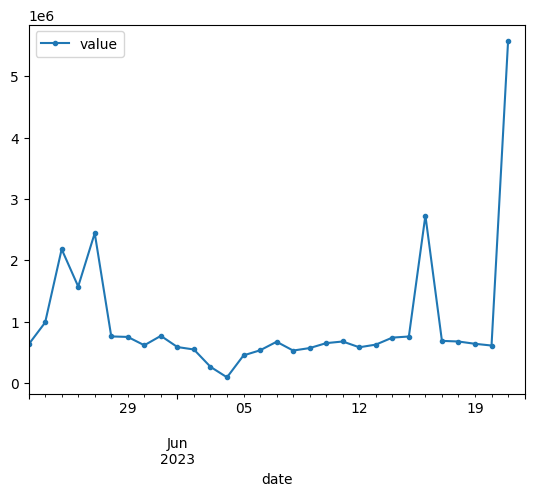

In [65]:
metric_id = 29
df = await query(metric_id)
df.plot(style='.-');

<Axes: xlabel='date'>

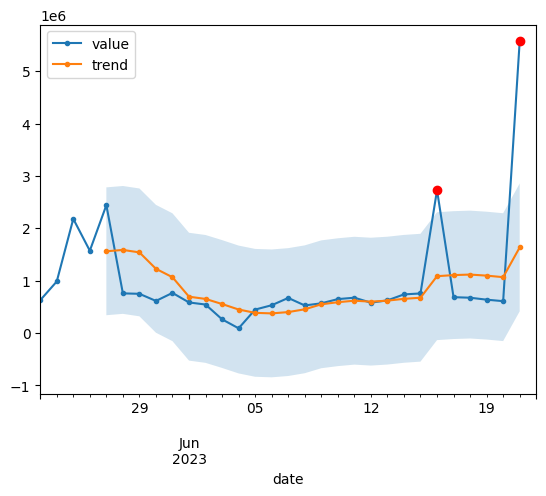

In [81]:
STD_MULTIPLIER = 3

df['trend'] = df['value'].rolling(5).mean()
std = df['trend'].std()
ax = df[['value', 'trend']].plot(style='.-');
# add noise level
d = df.index.to_pydatetime()
plt.fill_between(d, df['trend'] - std * STD_MULTIPLIER, df['trend'] + std * STD_MULTIPLIER, alpha=0.2)
# detect points
df['is_spike'] = (~df['value'].isna()) & ((df['trend'] - df['value']).abs() > std * STD_MULTIPLIER)
# mark
df['value'].where(df['is_spike']).plot(style='o', color='red')

In [107]:
# Verify it is the last point
import decimal
from mainapp.models import Measurement

@sync_to_async
def query_measurement():
    return Measurement.objects.exclude(value=float('nan')).filter(metric=metric_id).order_by('date').last()

await query_measurement()

<Measurement: 2023-06-21 = 5569208.05849338>

In [120]:
from mainapp.models import Metric
metric = await sync_to_async(Metric.objects.get)(pk=metric_id)
dashboard = await sync_to_async(metric.dashboards.first)()
await sync_to_async(dashboard.get_absolute_url)()

'/electricitymaps/mydash'